<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1_Best_Models_1_%2B_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [2]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [3]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [7]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [8]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [9]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [10]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [11]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [12]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [13]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [14]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [15]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [16]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

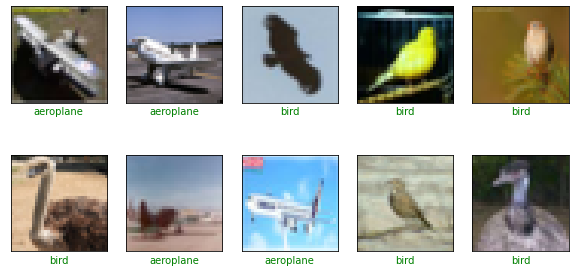

In [17]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [18]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [19]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [20]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [21]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


## Best Models
fundamentals-deep-learning-regularization-techniques/

In [22]:
from time import perf_counter 
from keras import regularizers
from keras.layers.core import Dropout

### Best Model 1 - (5.1.3)

Same as Model 5.1.2 with regularization - Dropout (0.10) + added layer (250 nodes) + output activation = sigmoid

In [23]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_13 = Sequential()
model_5_13.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_13.add(layers.Dense(units = 550, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(units = 300, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(units = 250, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(name = "output_layer", units = 10, activation = "sigmoid"))

model_5_13.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 550)               1690150   
                                                                 
 dropout (Dropout)           (None, 550)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               165300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_2 (Dense)             (None, 250)               75250     
                                                                 
 dropout_2 (Dropout)         (None, 250)               0

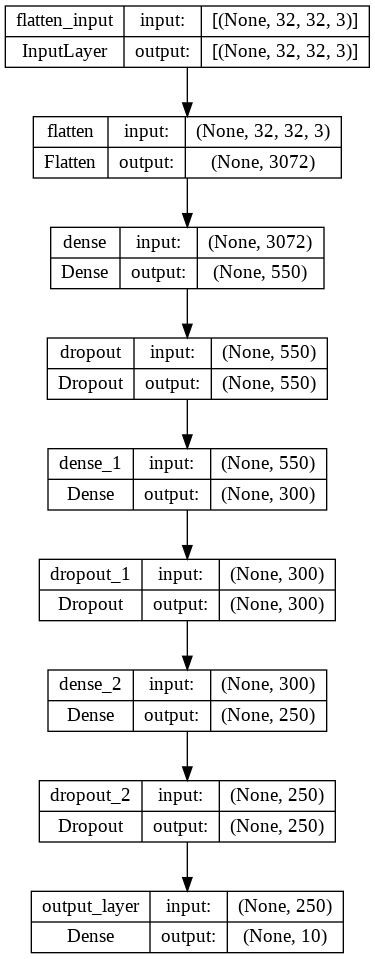

In [24]:
keras.utils.plot_model(model_5_13, "CIFAR_model.png", show_shapes=True) 

In [25]:
## Compile

model_5_13.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [26]:
## Train 
time = perf_counter()

history_5_13 = model_5_13.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_13.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 7ms/step - loss: 1.9363 - accuracy: 0.2928 - val_loss: 1.7624 - val_accuracy: 0.3592
Epoch 2/200
704/704 [==============================] - 4s 6ms/step - loss: 1.7707 - accuracy: 0.3607 - val_loss: 1.7473 - val_accuracy: 0.3650
Epoch 3/200
704/704 [==============================] - 4s 6ms/step - loss: 1.6971 - accuracy: 0.3926 - val_loss: 1.6800 - val_accuracy: 0.3956
Epoch 4/200
704/704 [==============================] - 4s 6ms/step - loss: 1.6526 - accuracy: 0.4065 - val_loss: 1.5796 - val_accuracy: 0.4288
Epoch 5/200
704/704 [==============================] - 5s 7ms/step - loss: 1.6163 - accuracy: 0.4170 - val_loss: 1.5765 - val_accuracy: 0.4330
Epoch 6/200
704/704 [==============================] - 4s 5ms/step - loss: 1.5924 - accuracy: 0.4272 - val_loss: 1.5559 - val_accuracy: 0.4366
Epoch 7/200
704/704 [==============================] - 4s 5ms/step - loss: 1.5718 - accuracy: 0.4348 - val_loss: 1.5741 - val_accuracy: 0.4302

In [27]:
time_5_13 = perf_counter() - time
print(time_5_13)

67.364367509


In [28]:
## Evaluate

model_5_13 = tf.keras.models.load_model("DNN_model_5_13.h5")
print(f"Test acc: {model_5_13.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.4310 - accuracy: 0.4942
Test acc: 0.494


#### Plot Metrics

In [29]:
history_dict_5_13 = history_5_13.history
history_dict_5_13.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
history_df_5_13=pd.DataFrame(history_dict_5_13)
history_df_5_13.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
12,1.476,0.468,1.477,0.464
13,1.466,0.472,1.490,0.471
14,1.460,0.475,1.514,0.450
15,1.447,0.480,1.468,0.470
16,1.435,0.485,1.486,0.462


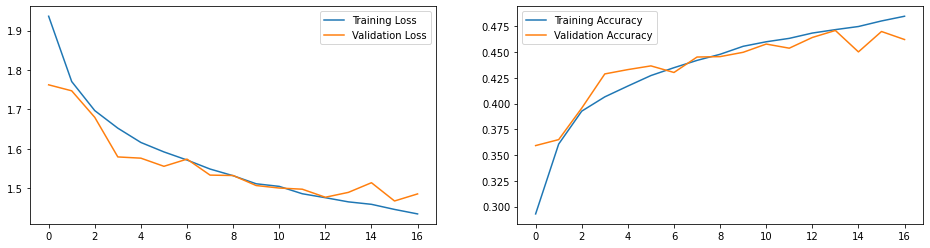

In [31]:
## Loss and acuracy
plot_history(history_5_13)

In [32]:
## Confusion matrix
pred_5_13= model_5_13.predict(x_test_norm)
pred_5_13=np.argmax(pred_5_13, axis=1)

313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


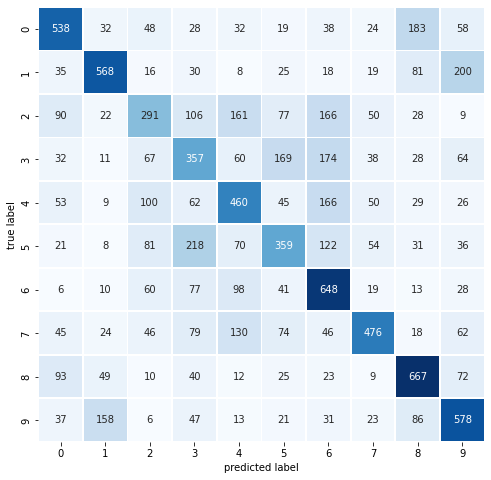

In [33]:
# Get the predicted classes:
pred_classes_5_13 = np.argmax(model_5_13.predict(x_test_norm), axis=-1)
pred_classes_5_13;

conf_mx_5_13 = tf.math.confusion_matrix(y_test, pred_classes_5_13)
conf_mx_5_13;

plot_confusion_matrix(y_test,pred_classes_5_13)

#### Activation and Performance

In [34]:
# Extracts the outputs of all layers:
layer_outputs_5_13 = [layer.output for layer in model_5_13.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_5_13 = models.Model(inputs=model_5_13.input, outputs=layer_outputs_5_13)

# Get activation values for the last dense layer
activations_5_13 = activation_model_5_13.predict(x_valid_norm[:3250])
dense_layer_activations_5_13 = activations_5_13[-3]
output_layer_activations_5_13 = activations_5_13[-1]

102/102 [==============================] - 0s 2ms/step


In [35]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_5_13 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_5_13 = tsne_5_13.fit_transform(dense_layer_activations_5_13)

# Scaling
tsne_results_5_13 = (tsne_results_5_13 - tsne_results_5_13.min()) / (tsne_results_5_13.max() - tsne_results_5_13.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...
[t-SNE] Computed neighbors for 3250 samples in 0.356s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 1.813511
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.895058
[t-SNE] KL divergence after 300 iterations: 1.965901


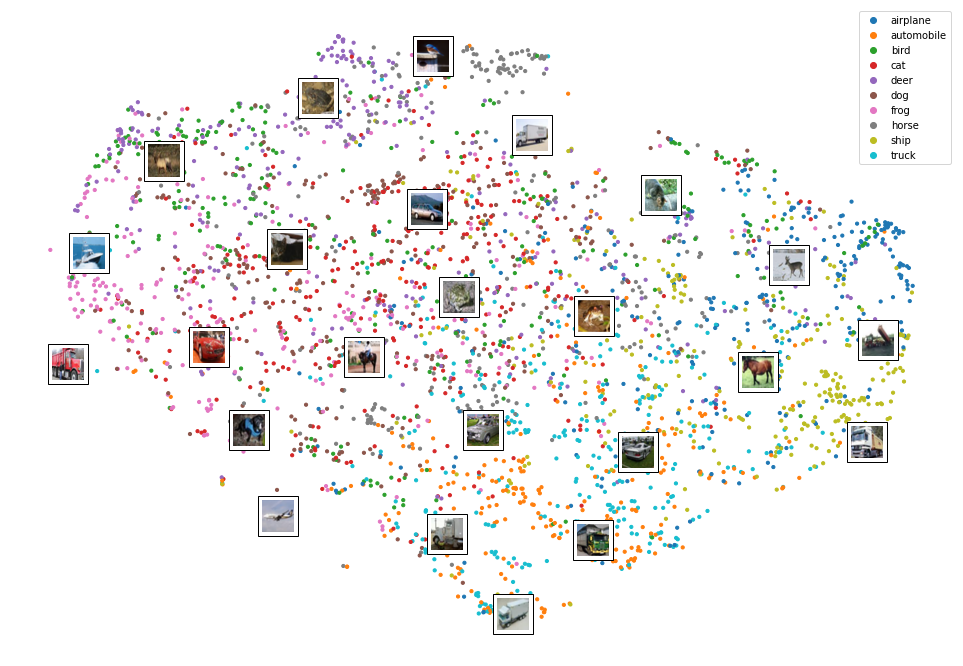

In [45]:
cmap_5_13 = plt.cm.tab10
plt.figure(figsize=(17,12))
scatter_5_13 = plt.scatter(tsne_results_5_13[:,0],tsne_results_5_13[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_5_13)
plt.legend(handles=scatter_5_13.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_5_13):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Best Model 2 (5.2.2)

Same as Model 5.2.1 with bais regularization L2, updated nodes (550, 300, 250)

In [46]:
from keras.regularizers import l2

model_5_22 = Sequential()
model_5_22.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_22.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_22.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 550)               1690150   
                                                                 
 dense_7 (Dense)             (None, 300)               165300    
                                                                 
 dense_8 (Dense)             (None, 250)               75250     
                                                                 
 output_layer (Dense)        (None, 10)                2510      
                                                                 
Total params: 1,933,210
Trainable params: 1,933,210
Non-trainable params: 0
_________________________________________________________________


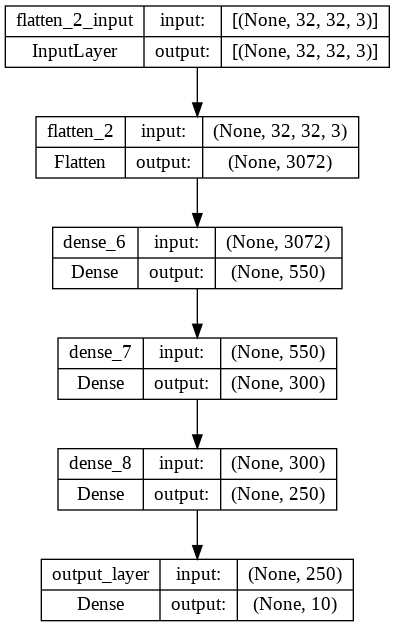

In [47]:
keras.utils.plot_model(model_5_22, "CIFAR_model.png", show_shapes=True) 

In [48]:
## Compile

model_5_22.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [49]:
## Train 
time = perf_counter()

history_5_22 = model_5_22.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_22.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8673 - accuracy: 0.3216 - val_loss: 1.7567 - val_accuracy: 0.3794
Epoch 2/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6928 - accuracy: 0.3922 - val_loss: 1.6894 - val_accuracy: 0.3940
Epoch 3/200
704/704 [==============================] - 3s 4ms/step - loss: 1.6070 - accuracy: 0.4243 - val_loss: 1.6996 - val_accuracy: 0.3988
Epoch 4/200
704/704 [==============================] - 3s 4ms/step - loss: 1.5439 - accuracy: 0.4490 - val_loss: 1.6204 - val_accuracy: 0.4164
Epoch 5/200
704/704 [==============================] - 3s 5ms/step - loss: 1.4973 - accuracy: 0.4652 - val_loss: 1.5376 - val_accuracy: 0.4414
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.4622 - accuracy: 0.4776 - val_loss: 1.5138 - val_accuracy: 0.4474
Epoch 7/200
704/704 [==============================] - 2s 4ms/step - loss: 1.4287 - accuracy: 0.4889 - val_loss: 1.5285 - val_accuracy: 0.4598

In [50]:
time_5_22 = perf_counter() - time
print(time_5_22)

46.315641411


In [51]:
## Evaluate

model_5_22 = tf.keras.models.load_model("DNN_model_5_22.h5")
print(f"Test acc: {model_5_22.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.4317 - accuracy: 0.4942
Test acc: 0.494


#### Plot Metrics

In [53]:
history_dict_5_22 = history_5_22.history
history_dict_5_22.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
history_df_5_22=pd.DataFrame(history_dict_5_22)
history_df_5_22.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
12,1.268,0.546,1.481,0.477
13,1.240,0.556,1.479,0.483
14,1.218,0.562,1.550,0.465
15,1.191,0.575,1.509,0.475
16,1.171,0.580,1.495,0.474


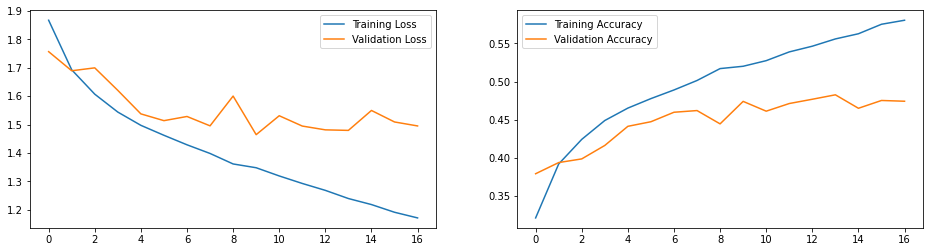

In [55]:
## Loss and acuracy
plot_history(history_5_22)

In [56]:
## Confusion matrix
pred_5_22= model_5_22.predict(x_test_norm)
pred_5_22=np.argmax(pred_5_22, axis=1)

313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


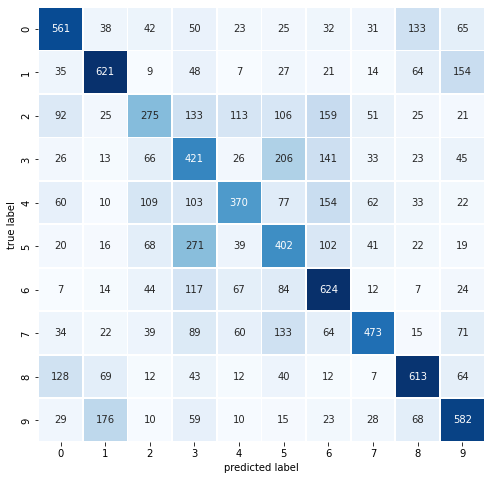

In [57]:
# Get the predicted classes:
pred_classes_5_22 = np.argmax(model_5_22.predict(x_test_norm), axis=-1)
pred_classes_5_22;

conf_mx_5_22 = tf.math.confusion_matrix(y_test, pred_classes_5_22)
conf_mx_5_22;

plot_confusion_matrix(y_test,pred_classes_5_22)

#### Activation and Performance

In [59]:
# Extracts the outputs of all layers:
layer_outputs_5_22 = [layer.output for layer in model_5_22.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_5_22 = models.Model(inputs=model_5_22.input, outputs=layer_outputs_5_22)

# Get activation values for the last dense layer
activations_5_22 = activation_model_5_22.predict(x_valid_norm[:3250])
dense_layer_activations_5_22 = activations_5_22[-3]
output_layer_activations_5_22 = activations_5_22[-1]

102/102 [==============================] - 0s 2ms/step


In [61]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_5_22 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_5_22 = tsne_5_22.fit_transform(dense_layer_activations_5_22)

# Scaling
tsne_results_5_22 = (tsne_results_5_22 - tsne_results_5_22.min()) / (tsne_results_5_22.max() - tsne_results_5_22.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...
[t-SNE] Computed neighbors for 3250 samples in 0.353s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 3.758207
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.634445
[t-SNE] KL divergence after 300 iterations: 2.301656


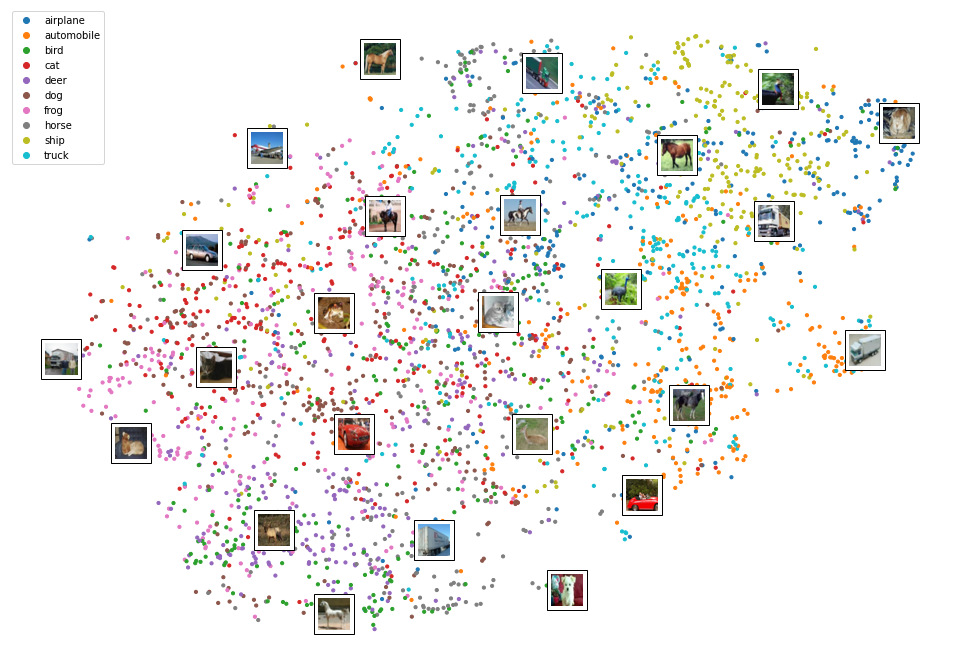

In [65]:
cmap_5_22 = plt.cm.tab10
plt.figure(figsize=(17,12))
scatter_5_22 = plt.scatter(tsne_results_5_22[:,0],tsne_results_5_22[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_5_22)
plt.legend(handles=scatter_5_22.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_5_22):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()